In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

%matplotlib inline

# Loading data

Data is provided by a link in the folder data. Enjoy yourself!!!

In [2]:
training_data = np.loadtxt('facial_recog/fer2013_training_onehot.csv', delimiter=',')

In [3]:
testing_data = np.loadtxt('facial_recog/fer2013_publictest_onehot.csv', delimiter=',')

In [4]:
training_data

array([[  70.,   80.,   82., ...,    0.,    0.,    0.],
       [ 151.,  150.,  147., ...,    0.,    0.,    0.],
       [ 231.,  212.,  156., ...,    0.,    0.,    0.],
       ..., 
       [  74.,   81.,   87., ...,    1.,    0.,    0.],
       [ 222.,  227.,  203., ...,    0.,    0.,    0.],
       [ 195.,  199.,  205., ...,    1.,    0.,    0.]])

In [5]:
def print_samples(data, n, label, emo_dict):
    seed = len(data)
    for i in range(n):
        j = random.randint(1, seed)
        sample_img = data[j, :]
        sample_img = np.reshape(sample_img, (48, 48))
        
        sample_label = label[j, : ]
        n_dict = np.argmax(sample_label)
        print('Emoion :', emo_dict[n_dict])
        plt.imshow(sample_img, cmap='gray')
        plt.show()
    

In [6]:
def load_data(train, test, n_inputs, n_classes):
    
    dim = len(train)
    x_tr = train[:, 0:n_inputs]
    y_tr = train[:, n_inputs:n_inputs + n_classes]
    
    x_te = test[:, 0:n_inputs]
    y_te = test[:, n_inputs:n_inputs + n_classes]
    
    x_tr = np.reshape(x_tr, (-1, 48, 48, 1))
    #x_tr = np.expand_dims(x_tr, axis=4)
    
    x_te = np.reshape(x_te, (-1, 48, 48, 1))
    #x_te = np.expand_dims(x_te, axis=4)
    
    return x_tr, y_tr, x_te, y_te

In [7]:
data_lenght = len(training_data)
n_inputs = 2304
n_classes = 7
X_tr, Y_tr, X_te, Y_te = load_data(training_data, testing_data, n_inputs, n_classes)

print('Training input data shape:', X_tr.shape)
print('Training labels data shape:', Y_tr.shape)
print('Testing input data shape:', X_te.shape)
print('Testing labels data shape:', Y_te.shape)


Training input data shape: (28709, 48, 48, 1)
Training labels data shape: (28709, 7)
Testing input data shape: (3589, 48, 48, 1)
Testing labels data shape: (3589, 7)


Emoion : happy


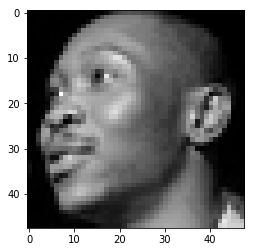

Emoion : fear


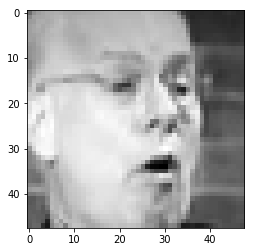

Emoion : angry


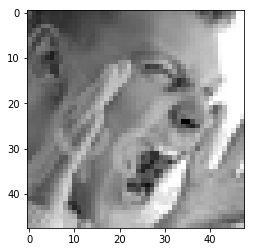

In [8]:
import random
emo_dict = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
samples = 3
print_samples(X_tr, samples, Y_tr, emo_dict)

In [36]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_tr, X_val, Y_tr, Y_val = train_test_split(X_tr, Y_tr, test_size=0.3, random_state=0)

In [135]:
tf.reset_default_graph()
sess = tf.Session()

In [136]:
def train(X_batch, Y_batch):
    total_loss = 0
    total_acc = 0
    samples = len(X_batch)
    sess = tf.get_default_session()
    for offset in range(0, samples, batch_size):
        end = offset+batch_size
        xs_batch, ys_batch = X_batch[offset:end], Y_batch[offset:end]
        loss_, acc = sess.run([loss, accuracy], feed_dict={x:xs_batch, y:ys_batch})
        total_loss += (float(loss_)*xs_batch.shape[0])
        total_acc += (float(acc)*xs_batch.shape[0])

    return (total_loss)/samples, (total_acc)/samples

In [137]:
def weight_var(shape):
    w = tf.truncated_normal(shape=shape, mean=0, stddev=0.1)
    return tf.Variable(w)

def bias_var(shape):
    return tf.Variable(tf.zeros(shape))


def CNN(x_):
    filter_ = 5
    strides1 = [1, 1, 1, 1]
    strides2 = [1, 2, 2, 1]
    ksize = strides2
    
    w1 = weight_var(shape=[3, 3, 1, 12])   
    b1 = bias_var(12)
    layer1 = tf.nn.conv2d(x_, w1, strides=strides1, padding='VALID')  #(, 44, 44, 64)
    layer1 = tf.nn.bias_add(layer1, b1)
    layer1 = tf.nn.relu(layer1)
    #print(layer1.get_shape)
    #layer1 = tf.nn.max_pool(layer1, ksize=ksize, strides=strides2, padding='VALID') #(, 22, 22, 64)
    
    
    w2 = weight_var(shape=[3, 3, 12, 16])
    b2 = bias_var(16)
    layer2 = tf.nn.conv2d(layer1, w2, strides=strides1, padding='VALID') #(, 18, 18, 64)
    layer2 = tf.nn.bias_add(layer2, b2)
    #print(layer2.get_shape)
    
    
    layer2 = tf.nn.relu(layer2)
    
    layer2 = tf.nn.max_pool(layer2, ksize=ksize, strides=strides2, padding='VALID') #(, 9, 9, 64)
    
    w3 = weight_var(shape=[3, 3, 16, 24])
    b3 = bias_var(24)
    layer3 = tf.nn.conv2d(layer2, w3, strides=strides1, padding='VALID')
    layer3 = tf.nn.bias_add(layer3, b3)
    layer3 = tf.nn.relu(layer3)
    #print(layer3.get_shape)
    #layer3= tf.nn.max_pool(layer3, ksize=ksize, strides=strides2, padding='VALID')
    h = layer3.get_shape
    #print(h)
    
    
    w4 = weight_var(shape=[3, 3, 24, 48])
    b4 = bias_var(48)
    layer4 = tf.nn.conv2d(layer3, w4, strides=strides1, padding='VALID')
    layer4 = tf.nn.bias_add(layer4, b4)
    layer4 = tf.nn.relu(layer4)
    #print(layer3.get_shape)
    layer4= tf.nn.max_pool(layer4, ksize=ksize, strides=strides2, padding='VALID')
    
    
    
    
    flatten = tf.contrib.layers.flatten(layer4)
    dim = flatten.get_shape().as_list()
    print(dim[1])
    wc1 = weight_var(shape=[(dim[1]), 512])
    b_c1 = bias_var(512)
    fc1 = tf.add(tf.matmul(flatten, wc1), b_c1)
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, 0.5)
    
    wc2 = weight_var(shape=[512, 64])
    b_c2 = bias_var(64)
    fc2 = tf.add(tf.matmul(fc1, wc2), b_c2)
    fc2 = tf.nn.relu(fc2)
    
    wc3 = weight_var(shape=[64, n_classes])
    b_c3 = bias_var(n_classes)
    logits = tf.matmul(fc2, wc3) + b_c3
    
    return logits
    
    
    
    

In [138]:


x = tf.placeholder(dtype=tf.float32, shape=(None, 48, 48, 1))
y = tf.placeholder(dtype=tf.float32, shape=(None, n_classes))

epochs = 60
batch_size = 512
logits = CNN(x)

3888


In [139]:
softmax = tf.nn.softmax(logits)
learning_rate = 8e-4
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.99).minimize(loss)

prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, dtype=tf.float32))



Initializing Training
EPOCH 1
Validation Loss = 2.083 and Validation Accuracy = 18.313 %
EPOCH 2
Validation Loss = 1.913 and Validation Accuracy = 22.009 %
EPOCH 3
Validation Loss = 1.867 and Validation Accuracy = 23.407 %
EPOCH 4
Validation Loss = 1.852 and Validation Accuracy = 24.331 %
EPOCH 5
Validation Loss = 1.831 and Validation Accuracy = 24.757 %
EPOCH 6
Validation Loss = 1.818 and Validation Accuracy = 25.586 %
EPOCH 7
Validation Loss = 1.809 and Validation Accuracy = 26.297 %
EPOCH 8
Validation Loss = 1.799 and Validation Accuracy = 26.439 %
EPOCH 9
Validation Loss = 1.778 and Validation Accuracy = 28.998 %
EPOCH 10
Validation Loss = 1.769 and Validation Accuracy = 29.448 %
EPOCH 11
Validation Loss = 1.738 and Validation Accuracy = 30.964 %
EPOCH 12
Validation Loss = 1.736 and Validation Accuracy = 31.012 %
EPOCH 13
Validation Loss = 1.712 and Validation Accuracy = 32.670 %
EPOCH 14
Validation Loss = 1.715 and Validation Accuracy = 31.793 %
EPOCH 15
Validation Loss = 1.712 an

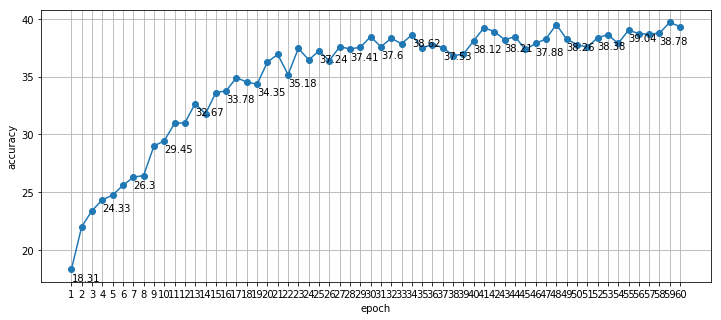

In [140]:
acc_map = []

#import shuffle

samples = len(X_tr)
print("Initializing Training")
try:
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        for epoch in range(epochs):
            X_train, Y_train = shuffle(X_tr, Y_tr)
            for offset in range(0, samples, batch_size):
                end = offset+batch_size
                xs_batch, ys_batch = X_train[offset:end], Y_train[offset:end]
                loss_, _, acc_ = sess.run([loss, optimizer, accuracy], feed_dict={x: xs_batch, y: ys_batch})
                
            validation_loss, validation_acc = train(X_val, Y_val)
            # acc map
            acc_map.append(round(validation_acc*100, 2))
            print("EPOCH {}".format(epoch + 1))
            print ("Validation Loss = {:.3f} and Validation Accuracy = {:.3f} %".format(validation_loss, 100 *validation_acc))
        plt.figure(figsize=(12, 5))
        plt.xticks(range(1, epochs+1))
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.grid(True)
        plt.plot(range(1, epochs+1), acc_map, '-o')
        for i, j in list(zip(range(1, epochs+1), acc_map))[0::3]:
            plt.text(i, j-1, str(j))
        
    
except KeyboardInterrupt:
    print('Training interrupted')